In [1]:
## Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
from tkinter import Tk
import tkinter
import imagecodecs
from tkinter.filedialog import askopenfilename
import os
from skimage import filters, measure, morphology
import math

In [2]:
tkinter._test()
plt.close('all')

In [3]:
# Use tkinter to open a file dialog and select one of the images
def select_file():
    Tk().withdraw()  # We don't want a full GUI, so keep the root window from appearing
    filename = askopenfilename(title="Select a Channel 1 TIFF Image", filetypes=[("TIFF files", "*.tif *.tiff")])
    return filename

# Select a file using the file dialog
selected_file = select_file()

In [ ]:
# Generate filenames for the other channels based on the selected file
base_name = os.path.splitext(selected_file)[0]
channel1_path = selected_file
channel2_path = base_name.replace("CH1", "CH2") + os.path.splitext(selected_file)[1]
channel3_path = base_name.replace("CH1", "CH3") + os.path.splitext(selected_file)[1]
channel4_path = base_name.replace("CH1", "CH4") + os.path.splitext(selected_file)[1]

# Load the images
channel1 = tiff.imread(channel1_path)[:, :, 2]
channel2 = tiff.imread(channel2_path)[:, :, 1]
channel3 = tiff.imread(channel3_path)[:, :, 0]
channel4 = tiff.imread(channel4_path)[:, :, 0]

# Combine channels into a single multi-channel image for convenience
image = np.stack((channel1, channel2, channel3, channel4), axis=-1)


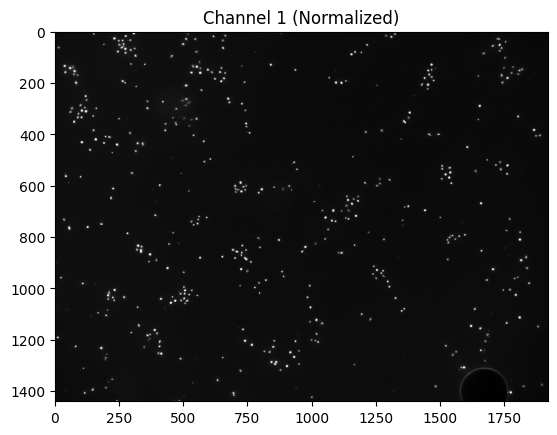

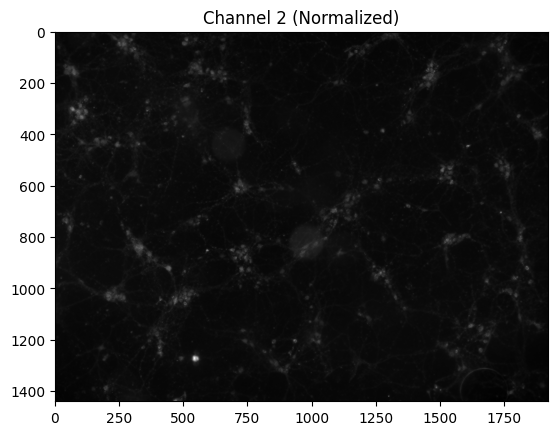

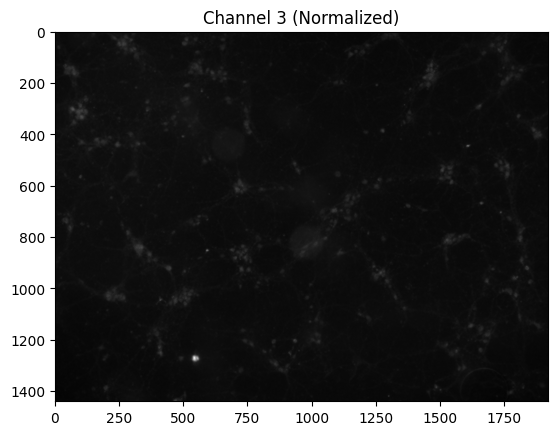

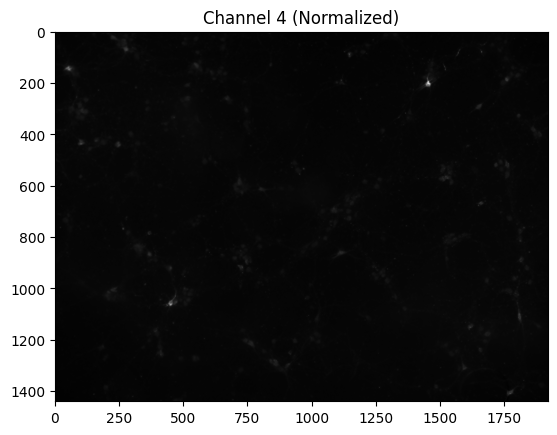

In [ ]:

# Normalize images for display
def normalize(image):
    return (image - np.min(image)) / (np.max(image) - np.min(image))

# Display one of the channels (normalized)
plt.imshow(normalize(channel1), cmap='gray')
plt.title('Channel 1 (Normalized)')
plt.show()

# Display one of the channels (normalized)
plt.imshow(normalize(channel2), cmap='gray')
plt.title('Channel 2 (Normalized)')
plt.show()

# Display one of the channels (normalized)
plt.imshow(normalize(channel3), cmap='gray')
plt.title('Channel 3 (Normalized)')
plt.show()

# Display one of the channels (normalized)
plt.imshow(normalize(channel4), cmap='gray')
plt.title('Channel 4 (Normalized)')
plt.show()

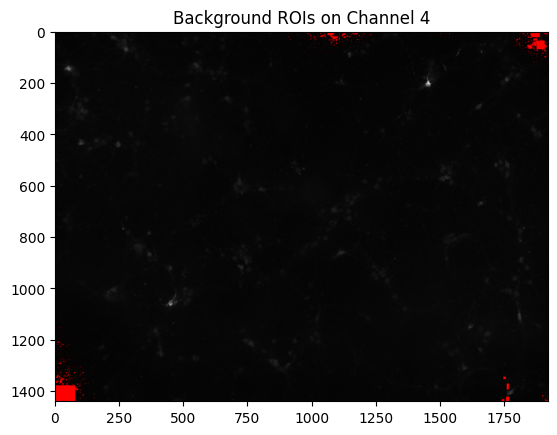

In [ ]:
# Find minima below a threshold to define background ROIs
background_threshold = 3600  # Adjust this value based on your needs
background_thresh = channel4 < background_threshold

# Label the background regions
background_labels = measure.label(background_thresh)
background_props = measure.regionprops(background_labels)

# Create bounding boxes around the detected background contours to define background ROIs
background_rois = []

for prop in background_props:
    minr, minc, maxr, maxc = prop.bbox[:4]
    background_rois.append((minc, minr, maxc - minc, maxr - minr))

# Display background ROIs on channel 1
background_roi_image = np.stack([normalize(channel4)]*3, axis=-1)  # Convert to RGB

for roi in background_rois:
    x, y, w, h = roi
    background_roi_image[y:y+h, x:x+w] = [1, 0, 0]  # Red for background ROIs

plt.imshow(background_roi_image)
plt.title('Background ROIs on Channel 4')
plt.show()


In [ ]:
# Initialize a list to store mean fluorescence values
mean_fluorescence = {f'Channel {i+1}': [] for i in range(image.shape[2])}
background_values = {f'Channel {i+1}': [] for i in range(image.shape[2])}

In [ ]:
# Calculate mean background values for each channel
for channel_index in range(image.shape[2]):
    channel = image[:, :, channel_index]
    
    for roi in background_rois:
        x, y, w, h = roi
        roi_area = channel[y:y+h, x:x+w]
        mean_background = np.mean(roi_area)
        background_values[f'Channel {channel_index+1}'].append(mean_background)

mean_background_value = []
# Subtract background from the entire image
background_subtracted_image = np.copy(image)
for channel_index in range(image.shape[2]):
    mean_background_value.append(np.mean(background_values[f'Channel {channel_index+1}']))
    background_subtracted_image[:, :, channel_index] -= np.minimum(math.floor(mean_background_value[channel_index]), background_subtracted_image[:, :, channel_index])

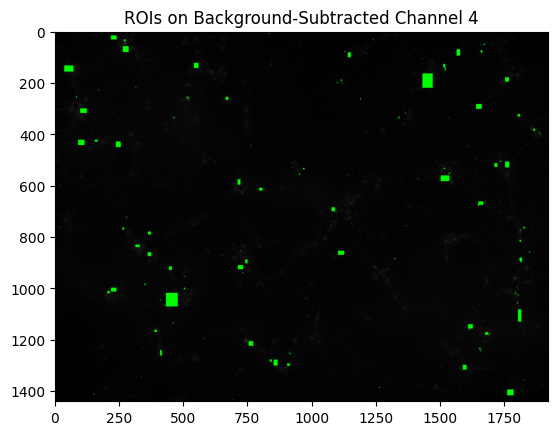

In [ ]:
# Apply a threshold to find maximum values in the background-subtracted channel 1
thresh = background_subtracted_image[:, :, 3] > 5000  # Adjust threshold value as needed

# Label the thresholded regions
labels = measure.label(thresh)
props = measure.regionprops(labels)

# Create bounding boxes around the detected contours to define ROIs
rois = []

for prop in props:
    minr, minc, maxr, maxc = prop.bbox[:4]
    rois.append((minc, minr, maxc - minc, maxr - minr))

# Display ROIs on the background-subtracted channel 1
roi_image = np.stack([normalize(background_subtracted_image[:, :, 3])]*3, axis=-1)  # Convert to RGB

for roi in rois:
    x, y, w, h = roi
    roi_image[y:y+h, x:x+w] = [0, 1, 0]  # Green for ROIs

plt.imshow(roi_image)
plt.title('ROIs on Background-Subtracted Channel 4')
plt.show()

In [ ]:
# Measure mean fluorescence in the ROIs for all channels
for channel_index in range(image.shape[2]):
    channel = background_subtracted_image[:, :, channel_index]
    
    for roi in rois:
        x, y, w, h = roi
        roi_area = channel[y:y+h, x:x+w]
        mean_value = np.mean(roi_area)
        mean_fluorescence[f'Channel {channel_index+1}'].append(mean_value)

mean_fluorescence_value = np.array([])

# Calculate mean fluorescence values for each channel
for channel_index in range(image.shape[2]):
    mean_fluorescence_value = np.append(mean_fluorescence_value, np.mean(mean_fluorescence[f'Channel {channel_index+1}']))

# Print the results
# for channel, values in mean_fluorescence.items():
#     print(f'{channel}: {values}')

print("mean_fluorescence_value: ", mean_fluorescence_value.tolist())
print("VP16 to GFP ratio: ", mean_fluorescence_value[1]/mean_fluorescence_value[3])

mean_fluorescence_value:  [5979.493546211789, 3909.5642919169236, 728.2090604183579, 5729.689247170797]
VP16 to GFP ratio:  0.6823344379186683
